# CrateDB and Linear Regression

In this notebook, we import Twitter data from CrateDB as a Pandas dataframe and then fit a linear regression model on that data. The goal is to predict the number of followers a user has depending on the number of people they are following, using regression analysis.

In [34]:
import numpy as np
import pandas as pd 

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
# you must manually install `crate` in the Anaconda environment, like so:
#
#     /anaconda3/bin/pip install crate

In [35]:
rcParams['axes.grid'] = True
rcParams['figure.figsize'] = 10,5

## Load the Data From CrateDB

In [36]:
limit = 100000
sql_query = """
    SELECT DISTINCT account_user['id'] AS id,
                    account_user['followers_count'] AS followers,
                    account_user['friends_count'] AS followees
               FROM tweets
              LIMIT {};
    """.format(limit)

# SQL query works out of the box with SQLAlchemy
try:
    # query CrateDB
    df_data = pd.read_sql(
        sql_query, 'crate://localhost:4200', index_col='id')
    # let's have a look at the first 5 rows
    display(df_data.head(5))
except Exception as error:
    print(error)
    print('CreatDB running and tweets imported?')

,followers,followees
id,,
746657251008585728,1790,88
1037581021422608385,224,209
2416723617,485,1015
1068985122836250624,29,1584
753823111842103296,16,72


## Explore the Data

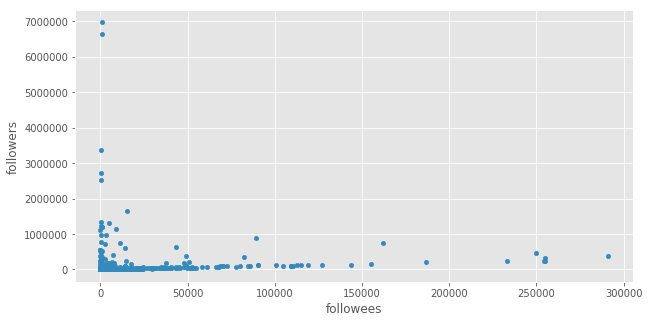

In [37]:
df_data.plot.scatter(x='followees', y='followers')
plt.show()

## Preprocess Data

In [39]:
# remove row if one value is zero, because log is -inf on zero
df_data = df_data.loc[~(df_data == 0).any(axis=1)] 

# apply log to followers and followees
df_data_transformed = df_data.apply(np.log10 )

# let's have a look at the first 5 rows after preprocessing data
display(df_data_transformed.head(5))

,followers,followees
id,,
746657251008585728,3.252853,1.944483
1037581021422608385,2.350248,2.320146
2416723617,2.685742,3.006466
1068985122836250624,1.462398,3.199755
753823111842103296,1.204120,1.857332


## Plot the Processed Data 

[Text(0,0.5,'log(followers)'), Text(0.5,0,'log(followees)')]

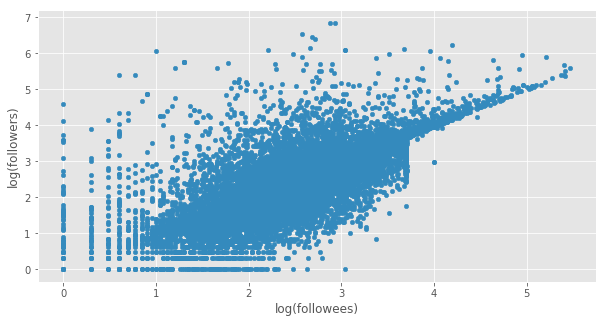

In [40]:
ax = df_data_transformed.plot.scatter(x='followees', y='followers')
ax.set(xlabel='log(followees)', ylabel='log(followers)')

## Split Into Training and Testing Data

In [41]:
# randomly split in train and test data
df_train, df_test = train_test_split(
    df_data_transformed, test_size=(1/3), random_state=42)

## Create a Base Model

In [42]:
average_followers = df_train.followers.mean()
display('Average followers '+ str(average_followers))

'Average followers 2.429029322032724'

## Evaluate the Base Model

In [43]:
# always use average_followers
followers_pred = np.full(len(df_test.followers), average_followers)

# the root mean squared error in the log space
print("Root mean squared error: %.2f" 
    % np.sqrt(mean_squared_error(df_test.followers, followers_pred)))

# variance score: 1 is perfect prediction
print('Variance score: %.2f'
    % r2_score(df_test.followers, followers_pred))

Root mean squared error: 0.86
Variance score: -0.00


## Create and Train a Linear Regression Model 

In [44]:
# create linear regression object
regr = LinearRegression()

# train the model using the training data
regr.fit(df_train[['followees']], df_train.followers)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Evaluate the Linear Regression Model 

In [49]:
# make predictions using the testing set
followers_pred = regr.predict(df_test[['followees']])

# the root mean squared error in the log space
print("Root mean squared error: %.2f"
      % np.sqrt(mean_squared_error(df_test.followers, followers_pred)))

# explained variance score: 1 is perfect prediction
print('Variance score: %.2f'
      % r2_score(df_test.followers, followers_pred))

Root mean squared error: 0.62
Variance score: 0.48


## Vizualize the Linear Regression Model

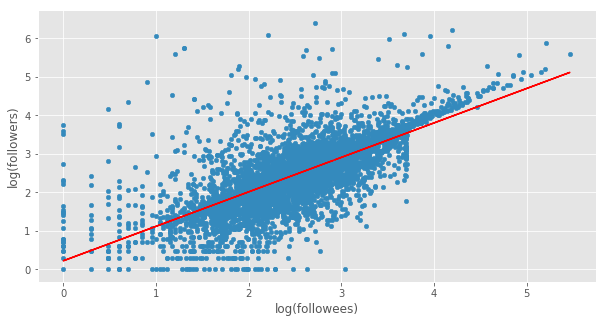

In [46]:
# plot outputs
ax = df_test.plot.scatter(x='followees', y='followers')
ax.set(xlabel='log(followees)', ylabel='log(followers)')
plt.plot(df_test.followees, followers_pred, color='red')

## Get the Original Values

In [50]:
# return it as a Dataframe
df_predicted = df_test[['followees']]
df_predicted['predicted_followers'] = followers_pred

inverse_log10 = lambda x: 10 ** x
# apply a reverse logarithmic transformation
df_predicted = df_predicted.apply(inverse_log10).astype(int)
df_predicted.head(10)

,followees,predicted_followers
id,,
3958268352,18,16
967930812564889600,13,12
830419953216008192,11,11
153583255,11,11
256544006,14,13
1703876994,3,3
136782824,6,7
202550910,27,23
1036644479602544640,12,12


## Write Back to CrateDB

In [48]:
# promote id from index type back as column, so it shows up in the table
df_predicted_reset = df_predicted.reset_index() 
df_predicted_reset.to_sql(
    'predicted_followers', 'crate://localhost',
    if_exists='append', index=False )